In [1]:
# python set up
import matplotlib.pyplot as plt
import math
from numpy import*
import pandas as pd
from scipy.stats import norm 
set_printoptions(threshold=float('inf'), linewidth= 200, suppress = True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
S0 = arange(4, 17, 1)
dt =  0.002
sd = 0.2
r = 0.04
K = 10
T = 0.5
dx1 = sd*sqrt(dt)
dx2 = sd*sqrt(3*dt)
dx3 = sd*sqrt(4*dt)

def generate_grid(sd, dx):

    return arange(log(16)+dx, log(4)-dx, -dx)

def Generate_Ps_EFD(dt, sd, r, dx):
    Pu = dt*(sd**2 / (2 * dx**2) + (r - 0.5*sd**2)/(2 * dx))
    Pm = 1 - dt*sd**2/dx**2 - r * dt
    Pd =  dt*(sd**2 / (2 * dx**2) - (r - 0.5*sd**2)/(2 * dx))
    return Pu, Pm, Pd

def A_Exlicit(Pu, Pm, Pd, grid_size):
    
    Pu_mtx = hstack((Pu*identity(grid_size - 2), 
                     zeros((grid_size - 2, 2))))

    Pm_mtx = hstack((zeros((grid_size - 2, 1)), 
                     Pm*identity((grid_size - 2)),
                     zeros((grid_size - 2, 1))))

    Pd_mtx = hstack((zeros((grid_size - 2, 2)), 
                    Pd*identity(grid_size - 2)))
    
    A = Pu_mtx + Pm_mtx + Pd_mtx
    A = vstack((A[0,:], A, A[-1,:]))
    
    return A

def ExplicitFinteDifferencePut(dt, sd, r, dx, S0, T):
    
    # Generate stock grids with the input parameters
    log_stock_gird = generate_grid(sd, dx)
    grid_size =  len(log_stock_gird)
    
    # select the index of the stocks that are closest to the $4 - $16 with $1 increment 
    idx = [abs(log_stock_gird - log(i)).argmin() for i in arange(3, 17, 1)]

    # Generate Pu, Pm, Pd
    Pu, Pm, Pd = Generate_Ps_EFD(dt, sd, r, dx)

    # Backward loop through the entire grid, solve the entire stock grid
    A = A_Exlicit(Pu, Pm, Pd, grid_size)
    B =  hstack((zeros(grid_size - 1), 
         exp(log_stock_gird[ -2]) -  exp(log_stock_gird[- 1])))

    F = maximum(K - exp(log_stock_gird), 0)
    for i in range(int(T/dt)):
            F = A.dot(F) + B
    
    # interporlate the stock prices that does not exsit in the grid
    P = interp(arange(4, 17, 1), exp(log_stock_gird[idx]), F[idx])
    
    return P

def Generate_Ps_IFD(dt, sd, r, dx):
    Pu = -1/2* dt*(sd**2 / dx**2 + (r - 0.5*sd**2)/ dx)
    Pm = 1 + dt*sd**2/dx**2 + r * dt
    Pd =  -1/2 * dt*(sd**2 /dx**2 - (r - 0.5*sd**2)/dx)
    return Pu, Pm, Pd

def A_Imlicit(Pu, Pm, Pd, grid_size):
    
    Pu_mtx = hstack((Pu*identity(grid_size - 2), 
                     zeros((grid_size - 2, 2))))

    Pm_mtx = hstack((zeros((grid_size - 2, 1)), 
                     Pm*identity((grid_size - 2)),
                     zeros((grid_size - 2, 1))))

    Pd_mtx = hstack((zeros((grid_size - 2, 2)), 
                    Pd*identity(grid_size - 2)))
    
    A = Pu_mtx + Pm_mtx + Pd_mtx
    A = vstack((hstack((1, -1, zeros(grid_size - 2))),
                A, 
                hstack((zeros(grid_size - 2), -1, 1))))
    
    return A

def ImplicitFinteDifferencePut(dt, sd, r, dx, S0, T):
    
    # Generate stock grids with the input parameters
    log_stock_gird = generate_grid(sd, dx)
    grid_size =  len(log_stock_gird)
    
    # select the index of the stocks that are closest to the $4 - $16 with $1 increment 
    idx = [abs(log_stock_gird - log(i)).argmin() for i in arange(1, 20, 1)]

    # Generate Pu, Pm, Pd
    Pu, Pm, Pd = Generate_Ps_IFD(dt, sd, r, dx)

    # Backward loop through the entire grid, solve the entire stock grid
    A_inv = linalg.inv(A_Imlicit(Pu, Pm, Pd, grid_size))
    
    # initialize matrix B
    B =  hstack((0, maximum(K - exp(log_stock_gird), 0)[1:-1],
                     exp(log_stock_gird[ -2]) -  exp(log_stock_gird[- 1])))

    for i in range(int(T/dt)):
       
        F = A_inv.dot(B)
        B =  hstack((0, F[1:-1],
                     exp(log_stock_gird[ -2]) -  exp(log_stock_gird[- 1])))
    
    # interporlate the stock prices that does not exsit in the grid
    P = interp(S0, exp(log_stock_gird[idx]), F[idx])
    
    return P

In [3]:
def Generate_Ps_CNFD(dt, sd, r, dx):
    Pu = -1/4* dt*(sd**2 / dx**2 + (r - 0.5*sd**2)/ dx)
    Pm = 1 + dt*sd**2/(2*dx**2) + 0.5* r * dt
    Pd =  -1/4 * dt*(sd**2 /dx**2 - (r - 0.5*sd**2)/dx)
    return Pu, Pm, Pd

def A_CNFD(Pu, Pm, Pd, grid_size):
    
    Pu_mtx = hstack((Pu*identity(grid_size - 2), 
                     zeros((grid_size - 2, 2))))

    Pm_mtx = hstack((zeros((grid_size - 2, 1)), 
                     Pm*identity((grid_size - 2)),
                     zeros((grid_size - 2, 1))))

    Pd_mtx = hstack((zeros((grid_size - 2, 2)), 
                    Pd*identity(grid_size - 2)))
    
    A = Pu_mtx + Pm_mtx + Pd_mtx
    A = vstack((hstack((1, -1, zeros(grid_size - 2))),
                A, 
                hstack((zeros(grid_size - 2), -1, 1))))
    
    return A

def CrankNicolsonFinteDifferencePut(dt, sd, r, dx, S0, T):
    
    # Generate stock grids with the input parameters
    log_stock_gird = generate_grid(sd, dx)
    grid_size =  len(log_stock_gird)
    
    # select the index of the stocks that are closest to the $4 - $16 with $1 increment 
    idx = [abs(log_stock_gird - log(i)).argmin() for i in arange(1, 20, 1)]

    # Generate Pu, Pm, Pd
    Pu, Pm, Pd = Generate_Ps_CNFD(dt, sd, r, dx)

    # Backward loop through the entire grid, solve the entire stock grid
    A_inv = linalg.inv(A_CNFD(Pu, Pm, Pd, grid_size))
    
    # initialize matrix B
    payoff = maximum(K - exp(log_stock_gird), 0)
    Z = -Pu*payoff[:-2] - (Pm - 2) * payoff[1:-1] - Pd*payoff[2:]
    B =  hstack((0, Z,
                     exp(log_stock_gird[ -2]) -  exp(log_stock_gird[- 1])))

    for i in range(int(T/dt)):
       
        F = A_inv.dot(B)
        Zi = -Pu*F[:-2] - (Pm - 2) * F[1:-1] - Pd*F[2:]
        B =  hstack((0, Zi,
                     exp(log_stock_gird[ -2]) -  exp(log_stock_gird[- 1])))
    
    # interporlate the stock prices that does not exsit in the grid
    P = interp(S0, exp(log_stock_gird[idx]), F[idx])
    
    return P

In [4]:
def BlackSholes_put(S0, sd, T, K, r):
    # find d1 and d2
    d1 = (log(S0/K) + (r + 0.5*sd**2)*T)/(sd*sqrt(T))
    d2 = d1 - sd*sqrt(T)

    # find call option price
    P =  K*exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1) 
    
    return (P)
bs_put = [BlackSholes_put(s0, 0.2, 0.5, 10, 0.04) for s0 in S0]
bs_put = pd.DataFrame(bs_put, index= S0)
bs_put.columns =['Black Scholes']

explicit_put_values = [ExplicitFinteDifferencePut(dt, sd, r, dx, S0, T) for dx in [dx1, dx2, dx3]]
explicit_put_values = pd.DataFrame(explicit_put_values, columns= S0).T
explicit_put_values = pd.concat([explicit_put_values, bs_put], axis=1)
explicit_put_values.columns = ['Explicit FD dx1', 'Explicit FD dx2', 'Explicit FD dx3', 'Black Scholes']
explicit_put_values['Error dx1'] = explicit_put_values.apply(lambda x: ((x['Explicit FD dx1'] 
                                                                           - x['Black Scholes'])), axis=1)
                                                                          

explicit_put_values['Error dx2'] = explicit_put_values.apply(lambda x: ((x['Explicit FD dx2'] 
                                                                         - x['Black Scholes'])), axis=1)

explicit_put_values['Error dx3'] = explicit_put_values.apply(lambda x: ((x['Explicit FD dx3'] 
                                                                         - x['Black Scholes'])), axis=1)
explicit_put_values.index.name = 'Stock Price (S0)'

explicit_put_values

,Explicit FD dx1,Explicit FD dx2,Explicit FD dx3,Black Scholes,Error dx1,Error dx2,Error dx3
Stock Price (S0),,,,,,,
4,5.80198,5.80198,5.80198,5.80199,-0.00001,-0.00001,-0.00001
5,4.80198,4.80198,4.80198,4.80199,-0.00001,-0.00001,-0.00001
6,3.80210,3.80205,3.80211,3.80206,0.00004,-0.00000,0.00005
7,2.80550,2.80565,2.80558,2.80536,0.00014,0.00029,0.00022
8,1.84583,1.84737,1.84784,1.84427,0.00156,0.00311,0.00357
9,1.02760,1.02693,1.02773,1.02443,0.00317,0.00250,0.00330
10,0.46985,0.47229,0.47162,0.46469,0.00516,0.00759,0.00692
11,0.17249,0.17481,0.17234,0.17154,0.00095,0.00328,0.00080
12,0.05342,0.05495,0.05346,0.05246,0.00096,0.00249,0.00100


In [5]:
implicit_put_values = [ImplicitFinteDifferencePut(dt, sd, r, dx, S0, T) for dx in [dx1, dx2, dx3]]
implicit_put_values = pd.DataFrame(implicit_put_values, columns= S0).T
implicit_put_values = pd.concat([implicit_put_values, bs_put], axis=1)
implicit_put_values.columns = ['Implicit FD dx1', 'Implicit FD dx2', 'Implicit FD dx3', 'Black Scholes']

implicit_put_values['Error dx1'] = implicit_put_values.apply(lambda x: (x['Implicit FD dx1'] 
                                                                           - x['Black Scholes']), axis=1)
                                                                          

implicit_put_values['Error dx2'] = implicit_put_values.apply(lambda x: (x['Implicit FD dx2'] 
                                                                         - x['Black Scholes']), axis=1)

implicit_put_values['Error dx3'] = implicit_put_values.apply(lambda x: (x['Implicit FD dx3'] 
                                                                         - x['Black Scholes']), axis=1)
implicit_put_values.index.name = 'Stock Price (S0)'
implicit_put_values


,Implicit FD dx1,Implicit FD dx2,Implicit FD dx3,Black Scholes,Error dx1,Error dx2,Error dx3
Stock Price (S0),,,,,,,
4,5.80199,5.80199,5.80199,5.80199,0.00001,0.00001,0.00000
5,4.80199,4.80199,4.80199,4.80199,0.00001,0.00000,0.00000
6,3.80213,3.80209,3.80214,3.80206,0.00007,0.00003,0.00008
7,2.80568,2.80583,2.80576,2.80536,0.00032,0.00047,0.00041
8,1.84620,1.84772,1.84818,1.84427,0.00193,0.00345,0.00391
9,1.02744,1.02682,1.02762,1.02443,0.00301,0.00240,0.00319
10,0.46936,0.47175,0.47108,0.46469,0.00466,0.00705,0.00638
11,0.17214,0.17450,0.17202,0.17154,0.00060,0.00297,0.00048
12,0.05347,0.05500,0.05352,0.05246,0.00101,0.00254,0.00106


In [6]:
CN_put_values = [CrankNicolsonFinteDifferencePut(dt, sd, r, dx, S0, T) for dx in [dx1, dx2, dx3]]
CN_put_values = pd.DataFrame(CN_put_values, columns= S0).T
CN_put_values = pd.concat([CN_put_values, bs_put], axis=1)
CN_put_values.columns = ['C-N FD dx1', 'C-N FD dx2', 'C-N FD dx3', 'Black Scholes']

CN_put_values['Error dx1'] = CN_put_values.apply(lambda x: x['C-N FD dx1'] - x['Black Scholes'], axis=1)
                                                                          
CN_put_values['Error dx2'] = CN_put_values.apply(lambda x: x['C-N FD dx2'] - x['Black Scholes'], axis=1)

CN_put_values['Error dx3'] = CN_put_values.apply(lambda x: x['C-N FD dx3'] - x['Black Scholes'], axis=1)
CN_put_values.index.name = 'Stock Price (S0)'
CN_put_values

,C-N FD dx1,C-N FD dx2,C-N FD dx3,Black Scholes,Error dx1,Error dx2,Error dx3
Stock Price (S0),,,,,,,
4,5.80199,5.80198,5.80198,5.80199,-0.00000,-0.00000,-0.00000
5,4.80199,4.80198,4.80198,4.80199,-0.00000,-0.00000,-0.00000
6,3.80212,3.80207,3.80212,3.80206,0.00006,0.00001,0.00006
7,2.80559,2.80574,2.80567,2.80536,0.00023,0.00038,0.00031
8,1.84603,1.84754,1.84801,1.84427,0.00176,0.00328,0.00374
9,1.02749,1.02688,1.02767,1.02443,0.00307,0.00245,0.00324
10,0.46963,0.47202,0.47135,0.46469,0.00494,0.00732,0.00665
11,0.17230,0.17466,0.17218,0.17154,0.00076,0.00312,0.00064
12,0.05344,0.05497,0.05349,0.05246,0.00098,0.00251,0.00103


In [7]:
S0 = arange(4, 17, 1)
dt =  0.002
sd = 0.2
r = 0.04
K = 10
T = 0.5
dS1 = 0.5
dS2 = 1
dS3 = 1.5

def generate_stock_gird(dS):
    
    return arange(0, 20, dS)

def Generate_aij_general(dt, sd, r, grid_size, alpha):
    
    # general a sequence from 1 to grid_size -1
    j = arange(1, grid_size - 1, 1)
    
    a1 = (sd**2 * j**2 - r * j)*(1 - alpha) / 2
    a2 = -1/dt - (sd**2 * j**2 + r)*(1 - alpha)
    a3 = (sd**2 * j**2 + r * j)*(1 - alpha) / 2
    
    return a1, a2, a3

def Generate_bij_general(dt, sd, r, grid_size, alpha):
    
    # general a sequence from 1 to grid_size -1
    j = arange(1, grid_size - 1, 1)
    
    b1 = (sd**2 * j**2 - r * j)* alpha / 2
    b2 =  1/dt - (sd**2 * j**2 + r)* alpha
    b3 = (sd**2 * j**2 + r * j)* alpha / 2
    
    return b1, b2, b3

def A_generalized(a1, a2, a3, grid_size):
    
    a1_mtx = hstack((diag(a1), 
                     zeros((grid_size - 2, 2))))

    a2_mtx = hstack((zeros((grid_size - 2, 1)), 
                     diag(a2),
                     zeros((grid_size - 2, 1))))

    a3_mtx = hstack((zeros((grid_size - 2, 2)), 
                    diag(a3)))
    
    A = a1_mtx + a2_mtx + a3_mtx
    A = vstack((hstack((a2[0], a3[0], zeros(grid_size - 2))),
                        A, 
                        hstack((zeros(grid_size - 2), a1[-1], a2[-1]))))
    return A

def B_generalized(b1, b2, b3, grid_size):
    
    b1_mtx = hstack((diag(-b1), 
                     zeros((grid_size - 2, 2))))

    b2_mtx = hstack((zeros((grid_size - 2, 1)), 
                     diag(-b2),
                     zeros((grid_size - 2, 1))))

    b3_mtx = hstack((zeros((grid_size - 2, 2)), 
                    diag(-b3)))
    
    B = b1_mtx + b2_mtx + b3_mtx
    B = vstack((hstack((-b2[0], -b3[0], zeros(grid_size - 2))),
                        B, 
                        hstack((zeros(grid_size - 2), -b1[-1], -b2[-1]))))
    return B

def GeneralizedFinteDifferenceCall(dt, sd, r, dS, S0, T, alpha):
    
    # Generate stock grids with the input parameters
    stock_gird = generate_stock_gird(dS)
    grid_size =  len(stock_gird)
    
    # select the index of the stocks that are closest to the $4 - $16 with $1 increment 
    idx =  [abs(stock_gird - i).argmin() for i in arange(1, 20, 1)]
    
    # Generate the 6 parameters
    a1, a2, a3 = Generate_aij_general(dt, sd, r, grid_size, alpha)
    b1, b2, b3 = Generate_bij_general(dt, sd, r, grid_size, alpha)
    
    # Generate matrix A and B
    A = A_generalized(a1, a2, a3, grid_size)
    B = B_generalized(b1, b2, b3, grid_size)
    
    # Backward loop through the entire grid, solve the entire stock grid
    A_inv = linalg.inv(A)
    F =  maximum(stock_gird - K, 0)
    
    
    for i in range(int(T/dt)):
        F = maximum(A_inv.dot(B.dot(F)), stock_gird - K)
        
    C =  interp(S0, stock_gird[idx], F[idx])
    return C, F

def GeneralizedFinteDifferencePut(dt, sd, r, dS, S0, T, alpha):
    
    # Generate stock grids with the input parameters
    stock_gird = generate_stock_gird(dS)
    grid_size =  len(stock_gird)
    
    # select the index of the stocks that are closest to the $4 - $16 with $1 increment 
    idx =  [abs(stock_gird - i).argmin() for i in arange(0, 21, 1)]
    
    # Generate the 6 parameters
    a1, a2, a3 = Generate_aij_general(dt, sd, r, grid_size, alpha)
    b1, b2, b3 = Generate_bij_general(dt, sd, r, grid_size, alpha)
    
    # Generate matrix A and B
    A = A_generalized(a1, a2, a3, grid_size)
    B = B_generalized(b1, b2, b3, grid_size)
    
    # Backward loop through the entire grid, solve the entire stock grid
    A_inv = linalg.inv(A)
    F =  maximum(K - stock_gird, 0)
    
    
    for i in range(int(T/dt)):
        F = maximum(A_inv.dot(B.dot(F)), K - stock_gird)
        
    P =  interp(S0, stock_gird[idx], F[idx])
    return P, F

In [8]:
alpha = 1
explicit_American_call = [GeneralizedFinteDifferenceCall(dt, sd, r, dS, S0, T, alpha)[0] for dS in [dS1, dS2, dS3]]
explicit_American_call = pd.DataFrame(explicit_American_call, columns= S0).T
explicit_American_call.columns = ['Explicit FD Call dS1', 'Explicit FD Call dS2', 'Explicit FD Call dS3']

explicit_American_put = [GeneralizedFinteDifferencePut(dt, sd, r, dS, S0, T, alpha)[0] for dS in [dS1, dS2, dS3]]
explicit_American_put = pd.DataFrame(explicit_American_put, columns= S0).T
explicit_American_put.columns = ['Explicit FD Put dS1', 'Explicit FD Put dS2', 'Explicit FD Put dS3']

alpha = 0
implicit_American_call = [GeneralizedFinteDifferenceCall(dt, sd, r, dS, S0, T, alpha)[0] for dS in [dS1, dS2, dS3]]
implicit_American_call = pd.DataFrame(implicit_American_call, columns= S0).T
implicit_American_call.columns = ['Implicit FD Call dS1', 'Implicit FD Call dS2', 'Implicit FD Call dS3']

implicit_American_put = [GeneralizedFinteDifferencePut(dt, sd, r, dS, S0, T, alpha)[0] for dS in [dS1, dS2, dS3]]
implicit_American_put = pd.DataFrame(implicit_American_put, columns= S0).T
implicit_American_put.columns = ['Implicit FD Put dS1', 'Implicit FD Put dS2', 'Implicit FD Put dS3']

alpha = 0.5
CN_American_call = [GeneralizedFinteDifferenceCall(dt, sd, r, dS, S0, T, alpha)[0] for dS in [dS1, dS2, dS3]]
CN_American_call = pd.DataFrame(CN_American_call, columns= S0).T
CN_American_call.columns = ['C-N FD Call dS1', 'C-N FD Call dS2', 'C-N FD Call dS3']

CN_American_put = [GeneralizedFinteDifferencePut(dt, sd, r, dS, S0, T, alpha)[0] for dS in [dS1, dS2, dS3]]
CN_American_put = pd.DataFrame(CN_American_put, columns= S0).T
CN_American_put.columns = ['C-N FD Put dS1', 'C-N FD Put dS2', 'C-N FD Put dS3']

summary2_call = pd.concat([explicit_American_call, implicit_American_call, CN_American_call], axis=1)
summary2_call.index.name = 'Stock Price (S0)'
summary2_call

,Explicit FD Call dS1,Explicit FD Call dS2,Explicit FD Call dS3,Implicit FD Call dS1,Implicit FD Call dS2,Implicit FD Call dS3,C-N FD Call dS1,C-N FD Call dS2,C-N FD Call dS3
Stock Price (S0),,,,,,,,,
4,0.00000,0.00000,0.00004,0.00000,0.00000,0.00004,0.00000,0.00000,0.00004
5,0.00000,0.00003,0.00065,0.00000,0.00003,0.00066,0.00000,0.00003,0.00065
6,0.00017,0.00051,0.00183,0.00019,0.00053,0.00187,0.00018,0.00052,0.00185
7,0.00406,0.00589,0.02021,0.00421,0.00603,0.02034,0.00413,0.00596,0.02027
8,0.04206,0.04292,0.09832,0.04240,0.04323,0.09844,0.04223,0.04307,0.09838
9,0.21668,0.20104,0.23617,0.21658,0.20105,0.23616,0.21663,0.20105,0.23616
10,0.65404,0.62305,0.73152,0.65343,0.62228,0.73117,0.65374,0.62266,0.73134
11,1.36416,1.34811,1.40568,1.36383,1.34782,1.40528,1.36399,1.34796,1.40548
12,2.24880,2.24489,2.25866,2.24878,2.24475,2.25850,2.24879,2.24476,2.25858


In [9]:
summary2_put = pd.concat([explicit_American_put, implicit_American_put, CN_American_put], axis=1)
summary2_put.index.name = 'Stock Price (S0)'
summary2_put

,Explicit FD Put dS1,Explicit FD Put dS2,Explicit FD Put dS3,Implicit FD Put dS1,Implicit FD Put dS2,Implicit FD Put dS3,C-N FD Put dS1,C-N FD Put dS2,C-N FD Put dS3
Stock Price (S0),,,,,,,,,
4,6.00000,6.00000,6.00000,6.00000,6.00000,6.00000,6.00000,6.00000,6.00000
5,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000
6,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000
7,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000,3.00000
8,2.00000,2.00000,2.01982,2.00000,2.00000,2.01979,2.00000,2.00000,2.01981
9,1.07575,1.05163,1.05946,1.07521,1.05125,1.05938,1.07548,1.05144,1.05942
10,0.47333,0.43998,0.54231,0.47245,0.43908,0.54197,0.47289,0.43953,0.54214
11,0.17068,0.15445,0.20951,0.17027,0.15417,0.20921,0.17047,0.15431,0.20936
12,0.05187,0.04815,0.06105,0.05192,0.04825,0.06110,0.05189,0.04820,0.06107


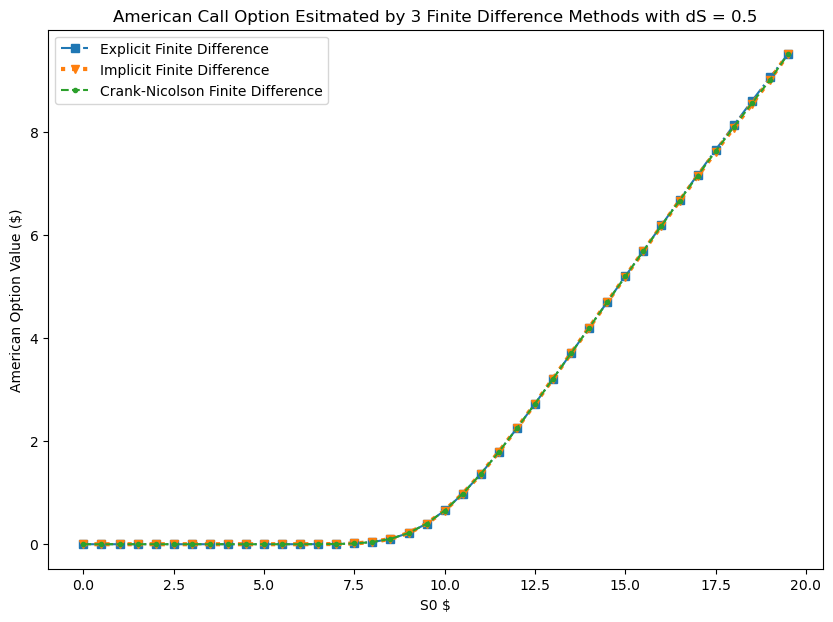

In [10]:
alpha = 1
EFD_American_call = [GeneralizedFinteDifferenceCall(dt, sd, r, dS, S0, T, alpha)[1] for dS in [dS1, dS2, dS3]]
stockgrid = [generate_stock_gird(dS) for dS in [dS1, dS2, dS3]]
alpha = 0
IFD_American_call = [GeneralizedFinteDifferenceCall(dt, sd, r, dS, S0, T, alpha)[1] for dS in [dS1, dS2, dS3]]
stockgrid = [generate_stock_gird(dS) for dS in [dS1, dS2, dS3]]
alpha = 0.5
CNFD_American_call = [GeneralizedFinteDifferenceCall(dt, sd, r, dS, S0, T, alpha)[1] for dS in [dS1, dS2, dS3]]
stockgrid = [generate_stock_gird(dS) for dS in [dS1, dS2, dS3]]

plt.figure(figsize=(10, 7))

plt.plot(stockgrid[0], EFD_American_call[0],  linestyle='-.', label = 'Explicit Finite Difference', 
         marker='s', markersize= 6)
plt.plot(stockgrid[0], IFD_American_call[0],  linestyle=':', linewidth=3, label =  'Implicit Finite Difference', 
         marker='v', markersize= 6)
plt.plot(stockgrid[0], CNFD_American_call[0],  linestyle='--', label = 'Crank-Nicolson Finite Difference', 
         marker='o', markersize= 3)

plt.legend()
plt.xlabel('S0 $')
plt.ylabel('American Option Value ($)')
plt.title('American Call Option Esitmated by 3 Finite Difference Methods with dS = 0.5')
plt.show()

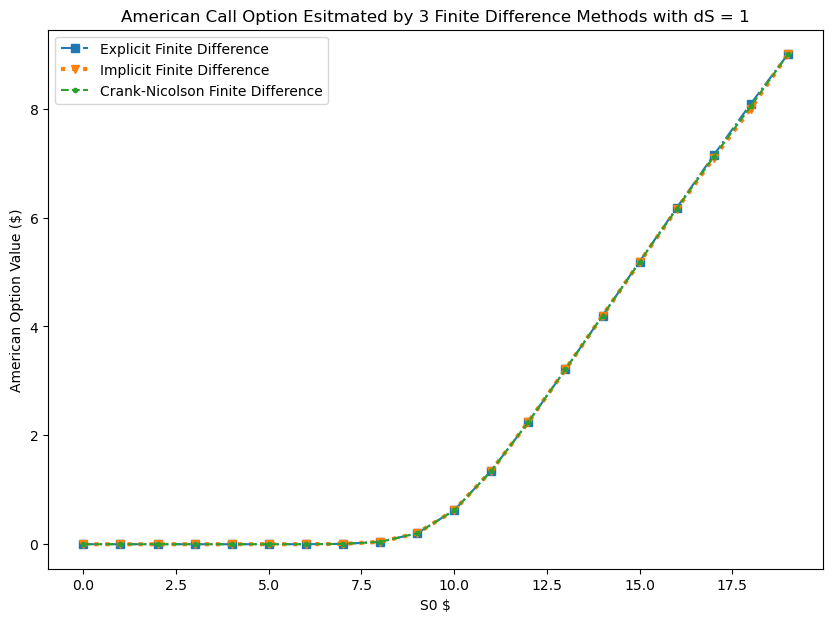

In [11]:
plt.figure(figsize=(10, 7))

plt.plot(stockgrid[1], EFD_American_call[1],  linestyle='-.', label = 'Explicit Finite Difference', 
         marker='s', markersize= 6)
plt.plot(stockgrid[1], IFD_American_call[1],  linestyle=':', linewidth=3, label =  'Implicit Finite Difference', 
         marker='v', markersize= 6)
plt.plot(stockgrid[1], CNFD_American_call[1],  linestyle='--', label = 'Crank-Nicolson Finite Difference', 
         marker='o', markersize= 3)

plt.legend()
plt.xlabel('S0 $')
plt.ylabel('American Option Value ($)')
plt.title('American Call Option Esitmated by 3 Finite Difference Methods with dS = 1')
plt.show()

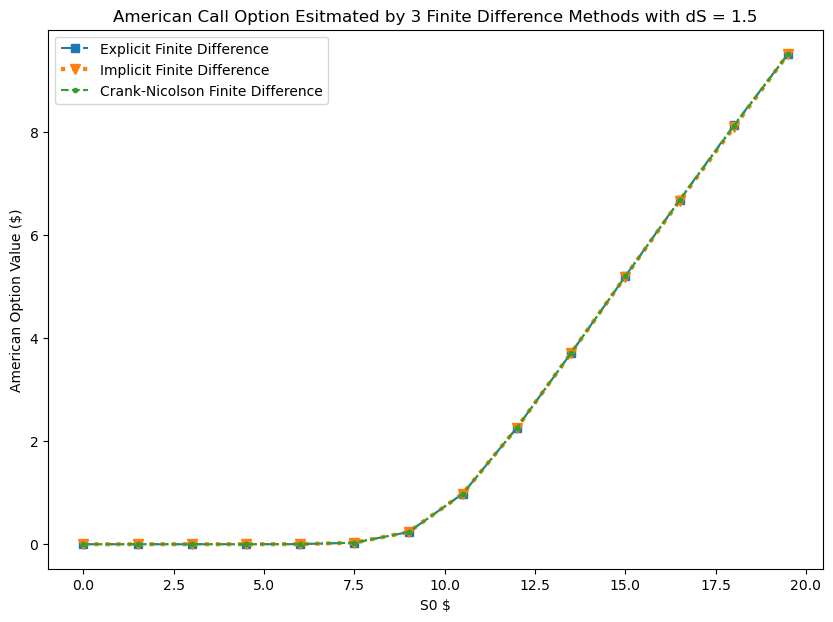

In [12]:
plt.figure(figsize=(10, 7))

plt.plot(stockgrid[2], EFD_American_call[2],  linestyle='-.', label = 'Explicit Finite Difference', 
         marker='s', markersize= 6)
plt.plot(stockgrid[2], IFD_American_call[2],  linewidth = 3, linestyle=':', label =  'Implicit Finite Difference', 
         marker='v', markersize= 7)
plt.plot(stockgrid[2], CNFD_American_call[2],  linestyle='--', label = 'Crank-Nicolson Finite Difference', 
         marker='o', markersize= 3)

plt.legend()
plt.xlabel('S0 $')
plt.ylabel('American Option Value ($)')
plt.title('American Call Option Esitmated by 3 Finite Difference Methods with dS = 1.5')
plt.show()

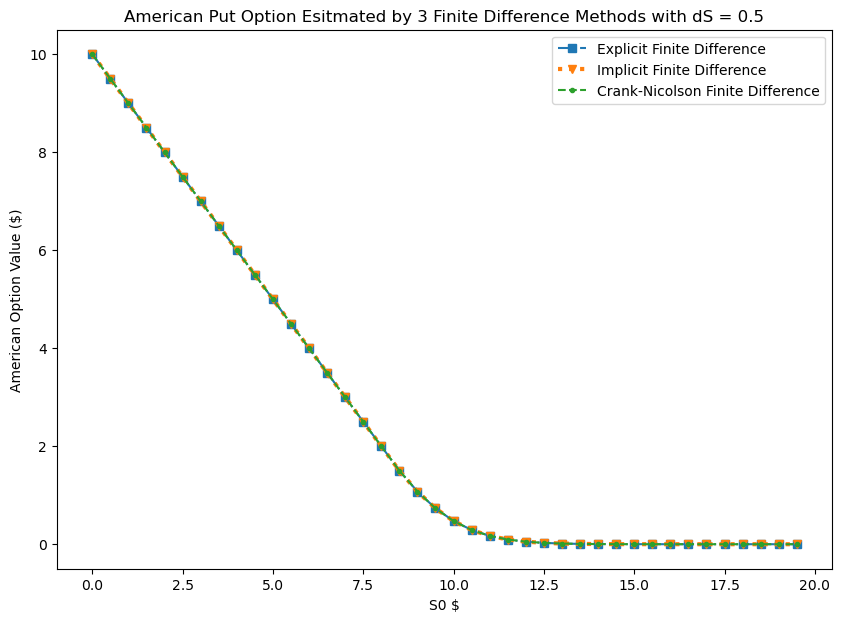

In [13]:
alpha = 1
EFD_American_put = [GeneralizedFinteDifferencePut(dt, sd, r, dS, S0, T, alpha)[1] for dS in [dS1, dS2, dS3]]
stockgrid = [generate_stock_gird(dS) for dS in [dS1, dS2, dS3]]
alpha = 0
IFD_American_put = [GeneralizedFinteDifferencePut(dt, sd, r, dS, S0, T, alpha)[1] for dS in [dS1, dS2, dS3]]
stockgrid = [generate_stock_gird(dS) for dS in [dS1, dS2, dS3]]
alpha = 0.5
CNFD_American_put = [GeneralizedFinteDifferencePut(dt, sd, r, dS, S0, T, alpha)[1] for dS in [dS1, dS2, dS3]]
stockgrid = [generate_stock_gird(dS) for dS in [dS1, dS2, dS3]]
plt.figure(figsize=(10, 7))

plt.plot(stockgrid[0], EFD_American_put[0],  linestyle='-.', label = 'Explicit Finite Difference', 
         marker='s', markersize= 6)
plt.plot(stockgrid[0], IFD_American_put[0],  linestyle=':', linewidth=3, label =  'Implicit Finite Difference', 
         marker='v', markersize= 6)
plt.plot(stockgrid[0], CNFD_American_put[0],  linestyle='--', label = 'Crank-Nicolson Finite Difference', 
         marker='o', markersize= 3)

plt.legend()
plt.xlabel('S0 $')
plt.ylabel('American Option Value ($)')
plt.title('American Put Option Esitmated by 3 Finite Difference Methods with dS = 0.5')
plt.show()

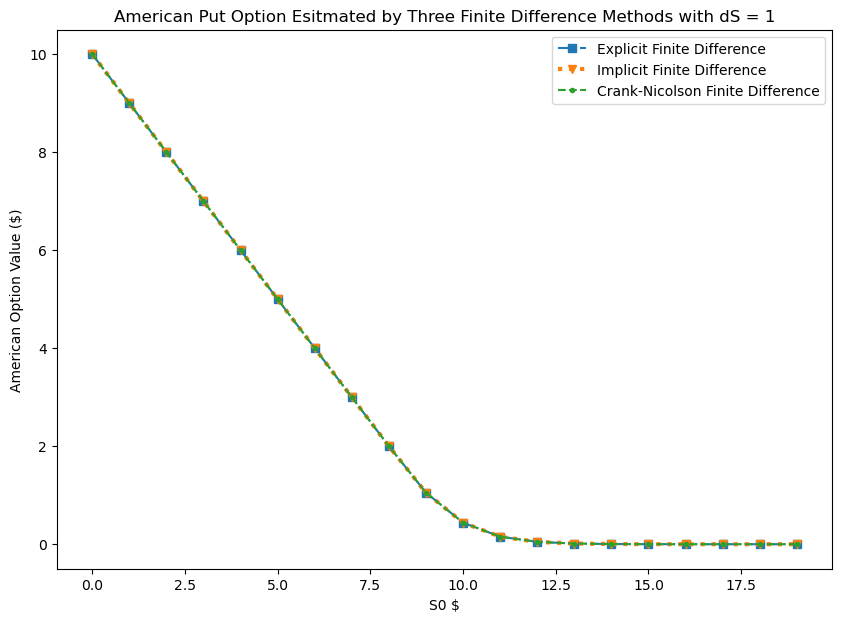

In [14]:
plt.figure(figsize=(10, 7))

plt.plot(stockgrid[1], EFD_American_put[1],  linestyle='-.', label = 'Explicit Finite Difference', 
         marker='s', markersize= 6)
plt.plot(stockgrid[1], IFD_American_put[1],  linestyle=':', linewidth=3, label =  'Implicit Finite Difference', 
         marker='v', markersize= 6)
plt.plot(stockgrid[1], CNFD_American_put[1],  linestyle='--', label = 'Crank-Nicolson Finite Difference', 
         marker='o', markersize= 3)

plt.legend()
plt.xlabel('S0 $')
plt.ylabel('American Option Value ($)')
plt.title('American Put Option Esitmated by Three Finite Difference Methods with dS = 1')
plt.show()

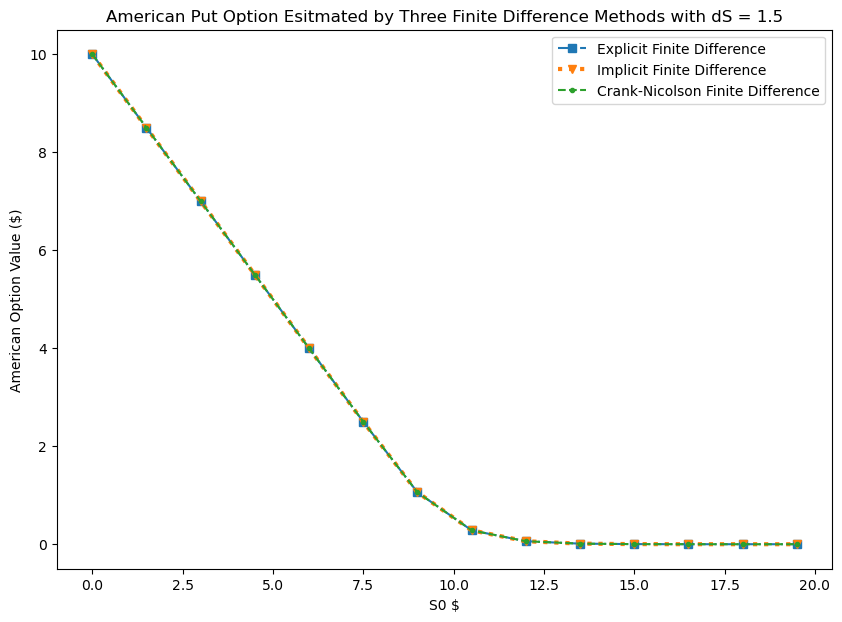

In [15]:
plt.figure(figsize=(10, 7))

plt.plot(stockgrid[2], EFD_American_put[2],  linestyle='-.', label = 'Explicit Finite Difference', 
         marker='s', markersize= 6)
plt.plot(stockgrid[2], IFD_American_put[2],  linestyle=':', linewidth=3, label =  'Implicit Finite Difference', 
         marker='v', markersize= 6)
plt.plot(stockgrid[2], CNFD_American_put[2],  linestyle='--', label = 'Crank-Nicolson Finite Difference', 
         marker='o', markersize= 3)

plt.legend()
plt.xlabel('S0 $')
plt.ylabel('American Option Value ($)')
plt.title('American Put Option Esitmated by Three Finite Difference Methods with dS = 1.5')
plt.show()